# Design

## Problem 4. Online App

You are designing a smart phone app

1. Users can subscribe for free, identified by their US phone number without extensions. Provide first and last name.
2. Users can add one or more credits cards to their account. Store zipcode, expiration date, and the CVC.
3. The app has paid add-ons called "Track & Field", "Marathon", and "Sprint", each with a fixed price.
4. A user can purchase each add-on, in which case she must provide a credit card for the purchase. A user cannot purchase the same addon twice.

In [1]:
import datajoint as dj

In [2]:
schema = dj.Schema('app')

[2023-09-19 23:12:49,751][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-09-19 23:12:49,831][INFO]: Connected root@fakeservices.datajoint.io:3306


In [15]:
@schema
class Account(dj.Manual):
    definition = """
    phone : bigint unsigned 
    ---
    first_name : varchar(30)
    last_name : varchar(30)
    """


In [65]:
@schema
class CreditCard(dj.Manual):
    definition = """
    card_number :  bigint unsigned 
    ---
    exp_date : date 
    cvc      : smallint unsigned
    zipcode  : int unsigned       
    -> Account
    """

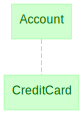

In [18]:
dj.Diagram(schema)

In [8]:
from faker import Faker
fake = Faker()

In [19]:
@schema
class AddOn(dj.Lookup):
    definition = """
    addon_id : int
    ---
    addon_name : varchar(30)
    price : decimal(5, 2) unsigned
    """

    contents = ((1, "Track & Field", 13.99), (2, "Marathon", 26.2), (3, "Sprint", 100.00))

In [20]:
AddOn()

addon_id,addon_name,price
1,Track & Field,13.99
2,Marathon,26.20
3,Sprint,100.00


In [21]:
@schema
class Purchase(dj.Manual):
    definition = """
    -> Account
    -> AddOn
    ---
    -> CreditCard
    """

In [67]:
CreditCard()

card_number,exp_date,cvc,zipcode,phone
30232728862999,2023-10-09,709,2832,14709094729


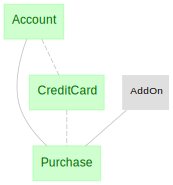

In [22]:
dj.Diagram(schema)

In [31]:
Account()

phone,first_name,last_name


In [34]:
Account.insert1(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name(),
    last_name=fake.last_name()))

In [36]:
Account.insert(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name(),
    last_name=fake.last_name()) for _ in range(10000))

In [64]:
2**16

65536

In [37]:
Account()

phone,first_name,last_name
10004941735,Allison,Underwood
10025366473,Christopher,Petty
10044826023,Alan,Reynolds
10050836680,Andrew,Morrison
10051646762,Katherine,Delgado
10057979176,Debbie,Zimmerman
10067431110,Drew,Reed
10070524656,Johnathan,Rodriguez
10072025793,Brent,Miller
10077808909,Jennifer,Young


In [38]:
CreditCard()

card_number,exp_date,cvc,zipcode,phone


In [44]:
keys = Account.fetch("KEY")

In [46]:
import random

In [ ]:
fake.credit_card_number

In [68]:
CreditCard.insert1(
    dict(random.choice(keys), 
         zipcode=random.randint(10000,99999), 
         card_number=int(fake.credit_card_number()),
         cvc=random.randint(1, 999), 
         exp_date=fake.future_date()))

In [73]:
CreditCard.insert(
    dict(random.choice(keys), 
         zipcode=random.randint(10000,99999), 
         card_number=int(fake.credit_card_number()),
         cvc=random.randint(1, 999), 
         exp_date=fake.future_date()) for _ in range(15000))

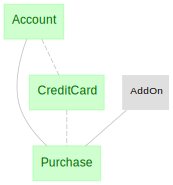

In [76]:
dj.Diagram(schema)

In [89]:
purchase_key = ((Account & CreditCard) * AddOn).fetch('KEY', limit=1)[0]

In [93]:
Purchase.insert1(dict(purchase_key, **(CreditCard & purchase_key).fetch('KEY')[0]))

In [94]:
Purchase()

phone,addon_id,card_number
10025366473,3,376154262563571


In [97]:
(Purchase * AddOn * Account).make_sql()

'SELECT `phone`,`addon_id`,`card_number`,`addon_name`,`price`,`first_name`,`last_name` FROM `app`.`purchase` NATURAL JOIN `app`.`#add_on` NATURAL JOIN `app`.`account`'